In [244]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn import tree

In [245]:
# Laddar upp datasetet. sep är för att tala om att det är delat med ;
dataSet = pd.read_csv('DataCSV.csv', sep=';', header =1)

In [246]:
# Tar bort alla deciamlkomma som störde ut hela filen
colsToDrop = [col for col in dataSet.columns if 'Unnamed' in col]
dataSet = dataSet.drop(columns=colsToDrop)

In [247]:
# Dela upp datan i target(y) och alla futeres(x) som den ska tränas på. 

targetColumn = 'Resultat'
y = dataSet[targetColumn]
x = dataSet.drop(targetColumn, axis=1)


In [248]:
# 1. Orginaldata 90/10

# Vi skapar listor för att spara resultaten av de 100  första körningarna. accuracy, precision, recall, och f1 score
resultTestOne = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1Score": []
    }

# Behöver skapa en tom matris som vi kan lägga in resultaten i för confusion matrix.
# Antal klasser (-1, 0, 1) 
numClasses = 3 

# Matris som summerar 100 iterationer

summorizedMatrix1 = np.zeros((numClasses, numClasses), dtype=int)

# Först loopen
for i in range(100):
    # Delning träning/testdata (90/10). Använder slump i delningen
    xTrain, xTest, yTrain, yTest  = train_test_split(x, y, test_size= 0.1, random_state=None)
    
    # Klassificerar beslutsträdet, random_state för att göra samma träd varje gång
    model = DecisionTreeClassifier(random_state=123)
    # Tränar modellen med träningsdatan
    model.fit(xTrain, yTrain)

    # Vi prediktar värden med modellen vi tränat på testdatan
    predictions = model.predict(xTest)

    # För att göra en confusion matrix behövs konvertering till index 0,1,2
    yTestIndexed = yTest + 1
    predictionsIndexed = predictions + 1

    # Beräkna matrix för denna loop
    matrixCurrent = confusion_matrix(yTestIndexed, predictionsIndexed, labels=range(numClasses))

    # Summera Matrix
    summorizedMatrix1 += matrixCurrent

    # Skapar rapporten och plockar ut datan. "out_put=True" = Returnerar rapporten som en dictionary istället för
    # att skriva ut den direkt. 
    report = classification_report(yTest, predictions, output_dict=True)

    # Sparar resultatetn från varje varv.
    resultTestOne["accuracy"].append(report['accuracy'])
    resultTestOne["precision"].append(report['weighted avg']['precision'])
    resultTestOne["recall"].append(report['weighted avg']['recall'])
    resultTestOne["f1Score"].append(report['weighted avg']['f1-score'])
    
#Skriver ut att loopen är klar
print("100 körningar gjorda.")

# Beräknar medelvärdena för resultaten
meanAccuracy1 = np.mean(resultTestOne["accuracy"])
meanPrecision1 = np.mean(resultTestOne["precision"])
meanRecall1 = np.mean(resultTestOne["recall"])
meanF11 = np.mean(resultTestOne["f1Score"])


100 körningar gjorda.


Metrics för Orginaldata med 90/10 fördelning

Summerad confusion matrix

[[6411  114  566]
 [ 117  919   68]
 [ 659  123 4623]]

Medelvärden

Medel Accuracy: 0.8789
Medel Precision: 0.8819
Medel Recall: 0.8789
Medel F1-Score: 0.8788

Aggregerad Classification Report (100 körningar)
-------------------------------------------------------
Klass       Precision     Recall   F1-Score    Support
-------------------------------------------------------
Phishing       0.8920     0.9041     0.8980       7091
Misstänkt      0.7950     0.8324     0.8133       1104
Legitimt       0.8794     0.8553     0.8672       5405



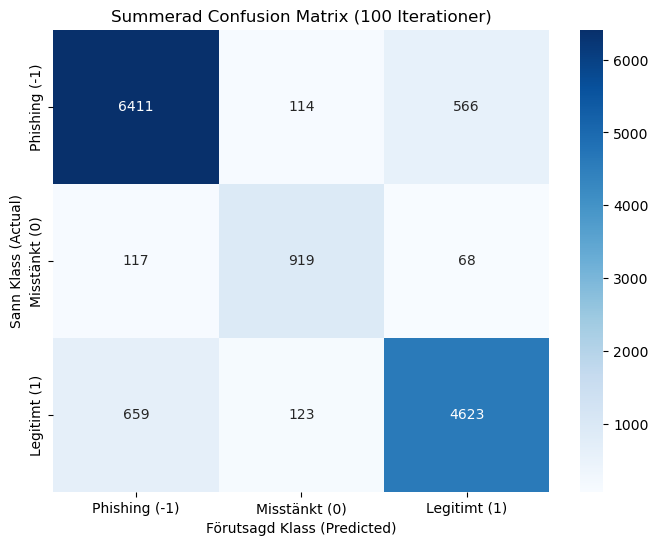

In [249]:

# Hämta TP, FN, FP för varje klass från matrisen.
# True Positives (TP) = Diagonalen i matrisen
TP = np.diag(summorizedMatrix1)

# False Negatives (FN) = Summan av varje rad minus TP
FN = np.sum(summorizedMatrix1, axis=1) - TP

# False Positives (FP) = Summan av varje kolumn minus TP
FP = np.sum(summorizedMatrix1, axis=0) - TP

# Beräkna måtten automatiskt med NumPy
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
support = np.sum(summorizedMatrix1, axis=1) # Antal sanna instanser per klass

# Presentera resultatet
target_names = ["Phishing", "Misstänkt", "Legitimt"]

print("Metrics för Orginaldata med 90/10 fördelning")
print()
print("Summerad confusion matrix")
print()
print(summorizedMatrix1)
print()

# Skriv ut medelvärden
print("Medelvärden")
print()
print(f"Medel Accuracy: {meanAccuracy1:.4f}")
print(f"Medel Precision: {meanPrecision1:.4f}")
print(f"Medel Recall: {meanRecall1:.4f}")
print(f"Medel F1-Score: {meanF11:.4f}")
print()
print("Aggregerad Classification Report (100 körningar)")
print("-" * 55)
print("{:<10} {:>10} {:>10} {:>10} {:>10}".format("Klass", "Precision", "Recall", "F1-Score", "Support"))
print("-" * 55)

for i, name in enumerate(target_names):
    print("{:<10} {:>10.4f} {:>10.4f} {:>10.4f} {:>10}".format(
        name,
        precision[i],
        recall[i],
        f1_score[i],
        support[i]
    ))
print()

# Presentera cm lite snyggare.

# Klassnamnen
classNames = ['Phishing (-1)', 'Misstänkt (0)', 'Legitimt (1)' ]

# Gör figuren och axlarna
plt.figure(figsize=(8, 6))

# Gör en heatmap
sns.heatmap(summorizedMatrix1, annot=True, fmt="d", cmap="Blues",
            xticklabels=classNames, yticklabels=classNames)

# Lägger till etiketter och titel
plt.title('Summerad Confusion Matrix (100 Iterationer)')
plt.ylabel('Sann Klass (Actual)')
plt.xlabel('Förutsagd Klass (Predicted)')

plt.show()

In [250]:
# 2. Orginaldata 70/30

resultTestTwo = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1Score": []
    }

# Behöver skapa en tom matris som vi kan lägga in resultaten i för confusion matrix.
# Antal klasser (-1, 0, 1) 
numClasses = 3 

# Matris som summerar 100 iterationer
summorizedMatrix2 = np.zeros((numClasses, numClasses), dtype=int)

# andra loopen
for i in range(100):
    # Delning träning/testdata (90/10). Använder slump i delningen
    xTrain, xTest, yTrain, yTest  = train_test_split(x, y, test_size= 0.3, random_state=None)
    
    # Klassificerar beslutsträdet, random_state för att göra samma träd varje gång
    model = DecisionTreeClassifier(random_state=123)
    # Tränar modellen med träningsdatan
    model.fit(xTrain, yTrain)

    # Vi prediktar värden med modellen vi tränat på testdatan
    predictions = model.predict(xTest)

    # För att göra en confusion matrix behövs konvertering till index 0,1,2
    yTestIndexed = yTest + 1
    predictionsIndexed = predictions + 1

    # Beräkna matrix för denna loop
    matrixCurrent = confusion_matrix(yTestIndexed, predictionsIndexed, labels=range(numClasses))

    # Summera Matrix
    summorizedMatrix2 += matrixCurrent

    # Skapar rapporten och plockar ut datan. "out_put=True" = Returnerar rapporten som en dictionary istället för
    # att skriva ut den direkt. 
    report = classification_report(yTest, predictions, output_dict=True)

    # Sparar resultatetn från varje varv.
    resultTestTwo["accuracy"].append(report['accuracy'])
    resultTestTwo["precision"].append(report['weighted avg']['precision'])
    resultTestTwo["recall"].append(report['weighted avg']['recall'])
    resultTestTwo["f1Score"].append(report['weighted avg']['f1-score'])
    
#Skriver ut att loopen är klar
print("100 körningar gjorda.")

# Beräknar medelvärdena för resultaten
meanAccuracy2 = np.mean(resultTestTwo["accuracy"])
meanPrecision2 = np.mean(resultTestTwo["precision"])
meanRecall2 = np.mean(resultTestTwo["recall"])
meanF12 = np.mean(resultTestTwo["f1Score"])

100 körningar gjorda.


Metrics för Orginaldata med 70/30 fördelning

Summerad confusion matrix

[[19040   334  1692]
 [  380  2494   236]
 [ 2133   392 13899]]

Medelvärden

Medel Accuracy: 0.8727
Medel Precision: 0.8741
Medel Recall: 0.8727
Medel F1-Score: 0.8726

Aggregerad Classification Report (100 körningar)
-------------------------------------------------------
Klass       Precision     Recall   F1-Score    Support
-------------------------------------------------------
Phishing       0.8834     0.9038     0.8935      21066
Misstänkt      0.7745     0.8019     0.7880       3110
Legitimt       0.8782     0.8463     0.8619      16424



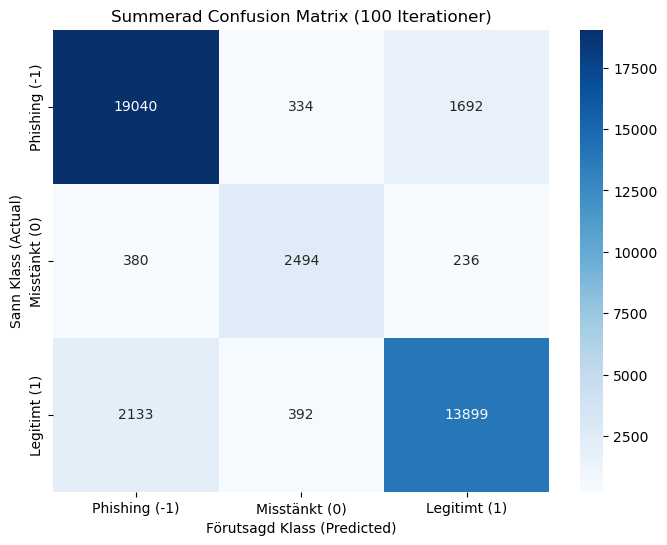

In [251]:

# Hämta TP, FN, FP för varje klass från matrisen.
# True Positives (TP) = Diagonalen i matrisen
TP = np.diag(summorizedMatrix2)

# False Negatives (FN) = Summan av varje rad minus TP
FN = np.sum(summorizedMatrix2, axis=1) - TP

# False Positives (FP) = Summan av varje kolumn minus TP
FP = np.sum(summorizedMatrix2, axis=0) - TP

# Beräkna måtten automatiskt med NumPy
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
support = np.sum(summorizedMatrix2, axis=1) # Antal sanna instanser per klass

# Presentera resultatet
target_names = ["Phishing", "Misstänkt", "Legitimt"]

print("Metrics för Orginaldata med 70/30 fördelning")
print()
print("Summerad confusion matrix")
print()
print(summorizedMatrix2)
print()

# Skriv ut medelvärden
print("Medelvärden")
print()
print(f"Medel Accuracy: {meanAccuracy2:.4f}")
print(f"Medel Precision: {meanPrecision2:.4f}")
print(f"Medel Recall: {meanRecall2:.4f}")
print(f"Medel F1-Score: {meanF12:.4f}")
print()
print("Aggregerad Classification Report (100 körningar)")
print("-" * 55)
print("{:<10} {:>10} {:>10} {:>10} {:>10}".format("Klass", "Precision", "Recall", "F1-Score", "Support"))
print("-" * 55)

for i, name in enumerate(target_names):
    print("{:<10} {:>10.4f} {:>10.4f} {:>10.4f} {:>10}".format(
        name,
        precision[i],
        recall[i],
        f1_score[i],
        support[i]
    ))
print()

# Presentera cm lite snyggare.

# Klassnamnen
classNames = ['Phishing (-1)', 'Misstänkt (0)', 'Legitimt (1)' ]

# Gör figuren och axlarna
plt.figure(figsize=(8, 6))

# Gör en heatmap
sns.heatmap(summorizedMatrix2, annot=True, fmt="d", cmap="Blues",
            xticklabels=classNames, yticklabels=classNames)

# Lägger till etiketter och titel
plt.title('Summerad Confusion Matrix (100 Iterationer)')
plt.ylabel('Sann Klass (Actual)')
plt.xlabel('Förutsagd Klass (Predicted)')

plt.show()

In [252]:
# 3. Normaliserad data 90/10

resultTestTree = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1Score": []
    }

# Behöver skapa en tom matris som vi kan lägga in resultaten i för confusion matrix.
# Antal klasser (-1, 0, 1) 
numClasses = 3 

# Matris som summerar 100 iterationer
summorizedMatrix3 = np.zeros((numClasses, numClasses), dtype=int)

# Initsierar skalaren
scaler = MinMaxScaler()
# Skapar variabler för normaliserat test
summorizedMatrixNormalized = np.zeros((numClasses, numClasses), dtype=int)
resultTestNormalized = {"accuracy": [], "precision": [], "recall": [], "f1Score": []}

# Tredje loopen
for i in range(100):
    # Delning träning/testdata (90/10). Använder slump i delningen
    xTrain, xTest, yTrain, yTest  = train_test_split(x, y, test_size= 0.1, random_state=None)
    
    # Normalisering - Endast på xTrain
    scaler.fit(xTrain)

    # Normaliserar på tränings och testdata.
    xTrainScaled = scaler.transform(xTrain)
    xTestScaled = scaler.transform(xTest)

    # Klassificerar beslutsträdet, random_state för att göra samma träd varje gång
    model = DecisionTreeClassifier(random_state=123)
    # Tränar modellen med träningsdatan, den normaliserade
    model.fit(xTrainScaled, yTrain)

    # Vi prediktar värden med modellen vi tränat på testdatan, den normaliserade
    predictions = model.predict(xTestScaled)

    # För att göra en confusion matrix behövs konvertering till index 0,1,2
    yTestIndexed = yTest + 1
    predictionsIndexed = predictions + 1

    # Beräkna matrix för denna loop
    matrixCurrent = confusion_matrix(yTestIndexed, predictionsIndexed, labels=range(numClasses))

    # Summera Matrix
    summorizedMatrix3 += matrixCurrent

    # Skapar rapporten och plockar ut datan. "out_put=True" = Returnerar rapporten som en dictionary istället för
    # att skriva ut den direkt. 
    report = classification_report(yTest, predictions, output_dict=True)

    # Sparar resultatetn från varje varv.
    resultTestTree["accuracy"].append(report['accuracy'])
    resultTestTree["precision"].append(report['weighted avg']['precision'])
    resultTestTree["recall"].append(report['weighted avg']['recall'])
    resultTestTree["f1Score"].append(report['weighted avg']['f1-score'])
    
#Skriver ut att loopen är klar
print("100 körningar gjorda.")

# Beräknar alla medelvärden
meanAccuracy3 = np.mean(resultTestTree["accuracy"])
meanPrecision3 = np.mean(resultTestTree["precision"])
meanRecall3 = np.mean(resultTestTree["recall"])
meanF13 = np.mean(resultTestTree["f1Score"])



100 körningar gjorda.


Metrics för Normaliserad data med 90/10 fördelning

Summerad confusion matrix

[[6377  100  513]
 [ 121  887   58]
 [ 688  108 4748]]

Medelvärden

Medel Accuracy: 0.8832
Medel Precision: 0.8859
Medel Recall: 0.8832
Medel F1-Score: 0.8831

Aggregerad Classification Report (100 körningar)
-------------------------------------------------------
Klass       Precision     Recall   F1-Score    Support
-------------------------------------------------------
Phishing       0.8874     0.9123     0.8997       6990
Misstänkt      0.8100     0.8321     0.8209       1066
Legitimt       0.8926     0.8564     0.8742       5544



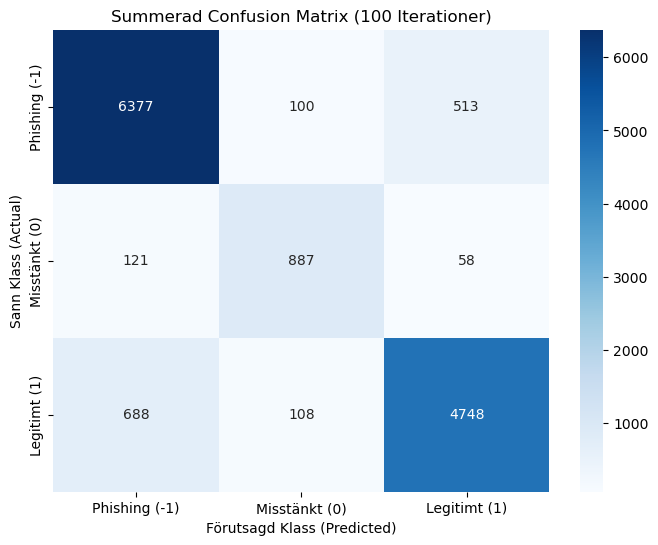

In [253]:
# Hämta TP, FN, FP för varje klass från matrisen.
# True Positives (TP) = Diagonalen i matrisen
TP = np.diag(summorizedMatrix3)

# False Negatives (FN) = Summan av varje rad minus TP
FN = np.sum(summorizedMatrix3, axis=1) - TP

# False Positives (FP) = Summan av varje kolumn minus TP
FP = np.sum(summorizedMatrix3, axis=0) - TP

# Beräkna måtten automatiskt med NumPy
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
support = np.sum(summorizedMatrix3, axis=1) # Antal sanna instanser per klass

# Presentera resultatet
target_names = ["Phishing", "Misstänkt", "Legitimt"]

print("Metrics för Normaliserad data med 90/10 fördelning")
print()
print("Summerad confusion matrix")
print()
print(summorizedMatrix3)
print()

# Skriv ut medelvärden
print("Medelvärden")
print()
print(f"Medel Accuracy: {meanAccuracy3:.4f}")
print(f"Medel Precision: {meanPrecision3:.4f}")
print(f"Medel Recall: {meanRecall3:.4f}")
print(f"Medel F1-Score: {meanF13:.4f}")
print()
print("Aggregerad Classification Report (100 körningar)")
print("-" * 55)
print("{:<10} {:>10} {:>10} {:>10} {:>10}".format("Klass", "Precision", "Recall", "F1-Score", "Support"))
print("-" * 55)

for i, name in enumerate(target_names):
    print("{:<10} {:>10.4f} {:>10.4f} {:>10.4f} {:>10}".format(
        name,
        precision[i],
        recall[i],
        f1_score[i],
        support[i]
    ))

print()

# Presentera cm lite snyggare.

# Klassnamnen
classNames = ['Phishing (-1)', 'Misstänkt (0)', 'Legitimt (1)' ]

# Gör figuren och axlarna
plt.figure(figsize=(8, 6))

# Gör en heatmap
sns.heatmap(summorizedMatrix3, annot=True, fmt="d", cmap="Blues",
            xticklabels=classNames, yticklabels=classNames)

# Lägger till etiketter och titel
plt.title('Summerad Confusion Matrix (100 Iterationer)')
plt.ylabel('Sann Klass (Actual)')
plt.xlabel('Förutsagd Klass (Predicted)')

plt.show()

In [254]:
# 4. Normaliserad data 70/30

resultTestFour = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1Score": []
    }

# Behöver skapa en tom matris som vi kan lägga in resultaten i för confusion matrix.
# Antal klasser (-1, 0, 1) 
numClasses = 3 

# Matris som summerar 100 iterationer
summorizedMatrix4 = np.zeros((numClasses, numClasses), dtype=int)

# Initsierar skalaren
scaler = MinMaxScaler()
# Skapar variabler för normaliserat test
summorizedMatrixNormalized = np.zeros((numClasses, numClasses), dtype=int)
resultTestNormalized = {"accuracy": [], "precision": [], "recall": [], "f1Score": []}

# Tredje loopen
for i in range(100):
    # Delning träning/testdata (90/10). Använder slump i delningen
    xTrain, xTest, yTrain, yTest  = train_test_split(x, y, test_size= 0.3, random_state=None)
    
    # Normalisering - Endast på xTrain
    scaler.fit(xTrain)

    # Normaliserar på tränings och testdata.
    xTrainScaled = scaler.transform(xTrain)
    xTestScaled = scaler.transform(xTest)

    # Klassificerar beslutsträdet, random_state för att göra samma träd varje gång
    model = DecisionTreeClassifier(random_state=123)
    # Tränar modellen med träningsdatan, den normaliserade
    model.fit(xTrainScaled, yTrain)

    # Vi prediktar värden med modellen vi tränat på testdatan, den normaliserade
    predictions = model.predict(xTestScaled)

    # För att göra en confusion matrix behövs konvertering till index 0,1,2
    yTestIndexed = yTest + 1
    predictionsIndexed = predictions + 1

    # Beräkna matrix för denna loop
    matrixCurrent = confusion_matrix(yTestIndexed, predictionsIndexed, labels=range(numClasses))

    # Summera Matrix
    summorizedMatrix4 += matrixCurrent

    # Skapar rapporten och plockar ut datan. "out_put=True" = Returnerar rapporten som en dictionary istället för
    # att skriva ut den direkt. 
    report = classification_report(yTest, predictions, output_dict=True)

    # Sparar resultatetn från varje varv.
    resultTestFour["accuracy"].append(report['accuracy'])
    resultTestFour["precision"].append(report['weighted avg']['precision'])
    resultTestFour["recall"].append(report['weighted avg']['recall'])
    resultTestFour["f1Score"].append(report['weighted avg']['f1-score'])
    
#Skriver ut att loopen är klar
print("100 körningar gjorda.")

# Beräknar alla medelvärden
meanAccuracy4 = np.mean(resultTestFour["accuracy"])
meanPrecision4 = np.mean(resultTestFour["precision"])
meanRecall4 = np.mean(resultTestFour["recall"])
meanF14 = np.mean(resultTestFour["f1Score"])



100 körningar gjorda.


Metrics för Normaliserad data med 70/30 fördelning

Summerad confusion matrix

[[19079   341  1651]
 [  366  2527   256]
 [ 2111   393 13876]]

Medelvärden

Medel Accuracy: 0.8739
Medel Precision: 0.8756
Medel Recall: 0.8739
Medel F1-Score: 0.8738

Aggregerad Classification Report (100 körningar)
-------------------------------------------------------
Klass       Precision     Recall   F1-Score    Support
-------------------------------------------------------
Phishing       0.8851     0.9055     0.8952      21071
Misstänkt      0.7749     0.8025     0.7885       3149
Legitimt       0.8792     0.8471     0.8629      16380



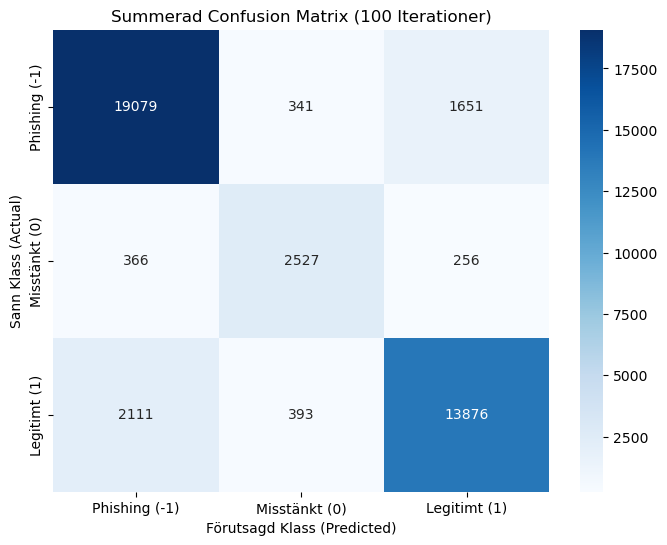

In [255]:
# Hämta TP, FN, FP för varje klass från matrisen.
# True Positives (TP) = Diagonalen i matrisen
TP = np.diag(summorizedMatrix4)

# False Negatives (FN) = Summan av varje rad minus TP
FN = np.sum(summorizedMatrix4, axis=1) - TP

# False Positives (FP) = Summan av varje kolumn minus TP
FP = np.sum(summorizedMatrix4, axis=0) - TP

# Beräkna måtten automatiskt med NumPy
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
support = np.sum(summorizedMatrix4, axis=1) # Antal sanna instanser per klass

# Presentera resultatet
target_names = ["Phishing", "Misstänkt", "Legitimt"]

print("Metrics för Normaliserad data med 70/30 fördelning")
print()
print("Summerad confusion matrix")
print()
print(summorizedMatrix4)
print()

# Skriv ut medelvärden
print("Medelvärden")
print()
print(f"Medel Accuracy: {meanAccuracy4:.4f}")
print(f"Medel Precision: {meanPrecision4:.4f}")
print(f"Medel Recall: {meanRecall4:.4f}")
print(f"Medel F1-Score: {meanF14:.4f}")
print()
print("Aggregerad Classification Report (100 körningar)")
print("-" * 55)
print("{:<10} {:>10} {:>10} {:>10} {:>10}".format("Klass", "Precision", "Recall", "F1-Score", "Support"))
print("-" * 55)

for i, name in enumerate(target_names):
    print("{:<10} {:>10.4f} {:>10.4f} {:>10.4f} {:>10}".format(
        name,
        precision[i],
        recall[i],
        f1_score[i],
        support[i]
    ))

print()

# Presentera cm lite snyggare.

# Klassnamnen
classNames = ['Phishing (-1)', 'Misstänkt (0)', 'Legitimt (1)' ]

# Gör figuren och axlarna
plt.figure(figsize=(8, 6))

# Gör en heatmap
sns.heatmap(summorizedMatrix4, annot=True, fmt="d", cmap="Blues",
            xticklabels=classNames, yticklabels=classNames)

# Lägger till etiketter och titel
plt.title('Summerad Confusion Matrix (100 Iterationer)')
plt.ylabel('Sann Klass (Actual)')
plt.xlabel('Förutsagd Klass (Predicted)')

plt.show()

In [256]:
print("Genomsnittlig noggranhet över 100 körningar")
print()
print(f"Körning: 1 | Fördelning: 90/10 | Data: Original     | Accuracy: {meanAccuracy1:.4f}")
print(f"Körning: 3 | Fördelning: 90/10 | Data: Normaliserad | Accuracy: {meanAccuracy3:.4f}")
print()
print(f"Körning: 2 | Fördelning: 70/30 | Data: Original     | Accuracy: {meanAccuracy2:.4f}")
print(f"Körning: 4 | Fördelning: 70/30 | Data: Normaliserad | Accuracy: {meanAccuracy4:.4f}")

Genomsnittlig noggranhet över 100 körningar

Körning: 1 | Fördelning: 90/10 | Data: Original     | Accuracy: 0.8789
Körning: 3 | Fördelning: 90/10 | Data: Normaliserad | Accuracy: 0.8832

Körning: 2 | Fördelning: 70/30 | Data: Original     | Accuracy: 0.8727
Körning: 4 | Fördelning: 70/30 | Data: Normaliserad | Accuracy: 0.8739
